In [176]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [117]:
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [109]:
RESOURCES_DIR = os.path.join(os.pardir, 'resources')
ISSUES_FILENAME = 'pycharm_issues.json'
RANDOM_STATE = 23923
EPS = 1e-9

## Data loading and preprocessing

In [ ]:
issues = pd.read_json(os.path.join(RESOURCES_DIR, ISSUES_FILENAME), lines=True)
issues['created'] = issues['created'].apply(lambda t: pd.to_datetime(t, unit='ms'))
issues['full_text'] = issues['summary'] + '. ' + issues['description']
issues.head()

In [55]:
issues['idReadable'].describe()

count        22014
unique       22014
top       PY-34359
freq             1
Name: idReadable, dtype: object

In [56]:
versions = np.unique(np.concatenate(issues['Affected versions'].ravel()))
versions

array(['2016.1', '2016.2', '2016.3', '2017.1', '2017.2', '2017.3',
       '2018.1', '2018.2', '2018.3', '2019.1', '2019.2', '2019.3',
       '2020.1', '2020.2', '2020.3', '2021.1', '2021.2', '2021.3'],
      dtype='<U32')

In [57]:
issues_by_version = {
    v: issues.loc[issues['Affected versions'].apply(lambda vs: v in vs)].drop(
        columns=['Affected versions', 'idReadable']) 
    for v in versions
}

In [ ]:
issues_by_version['2020.1'].head()

As we can see, some of the issues affect the release before its' launch. It can indicate both mistakes and unresolved issues. For example, the record below clearly indicates some inconsistency (if it was updated after creation, why did the initial affected version disappear?)

In [218]:
print(issues.iloc[12]['Affected versions'], issues.iloc[12]['created'])

['2020.1'] 2017-01-06 14:29:53.147000


In [47]:
stemmer = SnowballStemmer('english')

In [169]:
versions = versions[-5:]
versions

array(['2020.2', '2020.3', '2021.1', '2021.2', '2021.3'], dtype='<U32')

## Models

Let's start with a fairly simple approach: LDA model from sklearn on term frequencies. More specifically, we will build topics for different releases **separately**.

Another idea is to perform the analysis on summaries and descriptions independently. The reasoning behind it is that these fragments have different structures and words frequency distributions.

In [170]:
def find_top_words_sklearn(model, words, n_words=10):
    top_words = []
    for i, topic in enumerate(model.components_):
        order = np.argsort(topic)
        current_word = {words[order[-ind]]: (topic[order[-ind]], order[-ind]) 
                        for ind in range(1, min(n_words + 1, len(words)))}
        top_words.append(current_word)
    return top_words

First of all, let's find the best value for n_components based on the coherence metrics.

In [171]:
def evaluate_coherence(top_words, tfs):
    topic_mean_pmis = []
    for i, topic_words in enumerate(top_words):
        pmis = []
        for i, first_word in enumerate(top_words):
            for j in range(i + 1, len(top_words)):
                first_mask = (tfs[:, first_word] > 0).todense()
                second_mask = (tfs[:, top_words[j]] > 0).todense()
                p_i = first_mask.mean()
                p_j = second_mask.mean()
                p_ij = (first_mask & second_mask).mean()
                pmis.append(np.log(EPS + p_ij / (p_i * p_j)))
        topic_mean_pmis.append(np.mean(pmis))
    return np.mean(topic_mean_pmis)

In [172]:
coherences = []
for n_components in tqdm(range(2, 16)):
    current_coherences = []
    for version in versions:
        tf_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
        tfs = tf_vectorizer.fit_transform(issues_by_version[version]['full_text'].values.astype('U'))
        lda = LatentDirichletAllocation(n_components=n_components, random_state=RANDOM_STATE)
        lda.fit(tfs)
        top_words = find_top_words_sklearn(lda, tf_vectorizer.get_feature_names())
        current_coherences.append(
            evaluate_coherence([[v[1] for v in topic.values()] for topic in top_words], tfs))
    coherences.append(np.mean(current_coherences))

100%|██████████| 14/14 [02:26<00:00, 10.49s/it]


In [173]:
import matplotlib.pyplot as plt

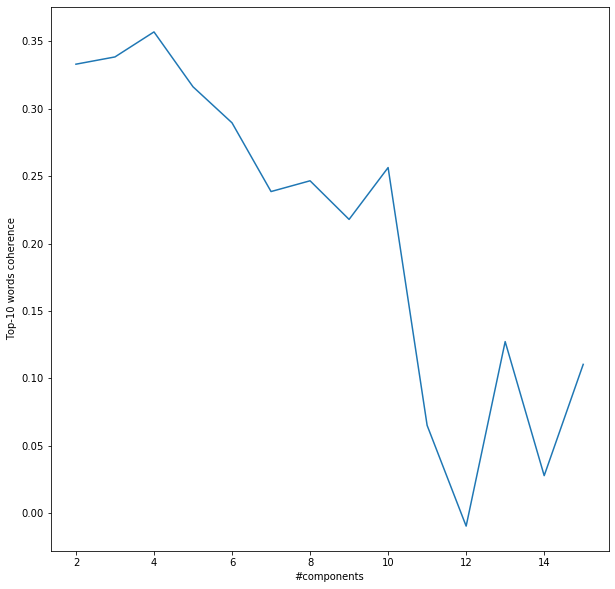

In [175]:
plt.rcParams.update({'figure.figsize': (10, 10)})
plt.clf()
plt.plot(range(2, 16), coherences)
plt.xlabel('#components')
plt.ylabel('Top-10 words coherence')
plt.show()

As we can see, ~4 or ~10 topics indicate the best coherence. However, here I don't consider cases where different versions correspond to a different number of topics.

Now, let's try to improve our score for the best numbers of topics by using bigrams.

In [200]:
top_words = {}
for n_components in tqdm([4, 10]):
    top_words[n_components] = {}
    for version in versions:
        tf_vectorizer = CountVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
        tfs = tf_vectorizer.fit_transform(issues_by_version[version]['full_text'].values.astype('U'))
        lda = LatentDirichletAllocation(n_components=n_components, random_state=RANDOM_STATE)
        lda.fit(tfs)
        top_words[n_components][version] = find_top_words_sklearn(lda, tf_vectorizer.get_feature_names())

100%|██████████| 2/2 [00:19<00:00,  9.60s/it]


Plot bellow is inspired by [this example](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py).

In [201]:
def generate_top_words_barplot(word_weights, title, labels=None):
    n_components = len(word_weights)
    if labels is None:
        labels = [f'Topic {i}' for i in range(1, 1 + n_components)]
    fig, axes = plt.subplots(2, n_components // 2, figsize=(30, 20), sharex=True)
    for i, ax in enumerate(axes.flatten()):
        weights = np.array([v[1] for v in word_weights[i].values()])
        words = np.array(list(word_weights[i].keys()), dtype='object')
        order = np.argsort(weights)
        ax.barh(words[order], weights[order], height=0.7)
        ax.set_title(labels[i], fontdict={'fontsize': 30})
        # ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

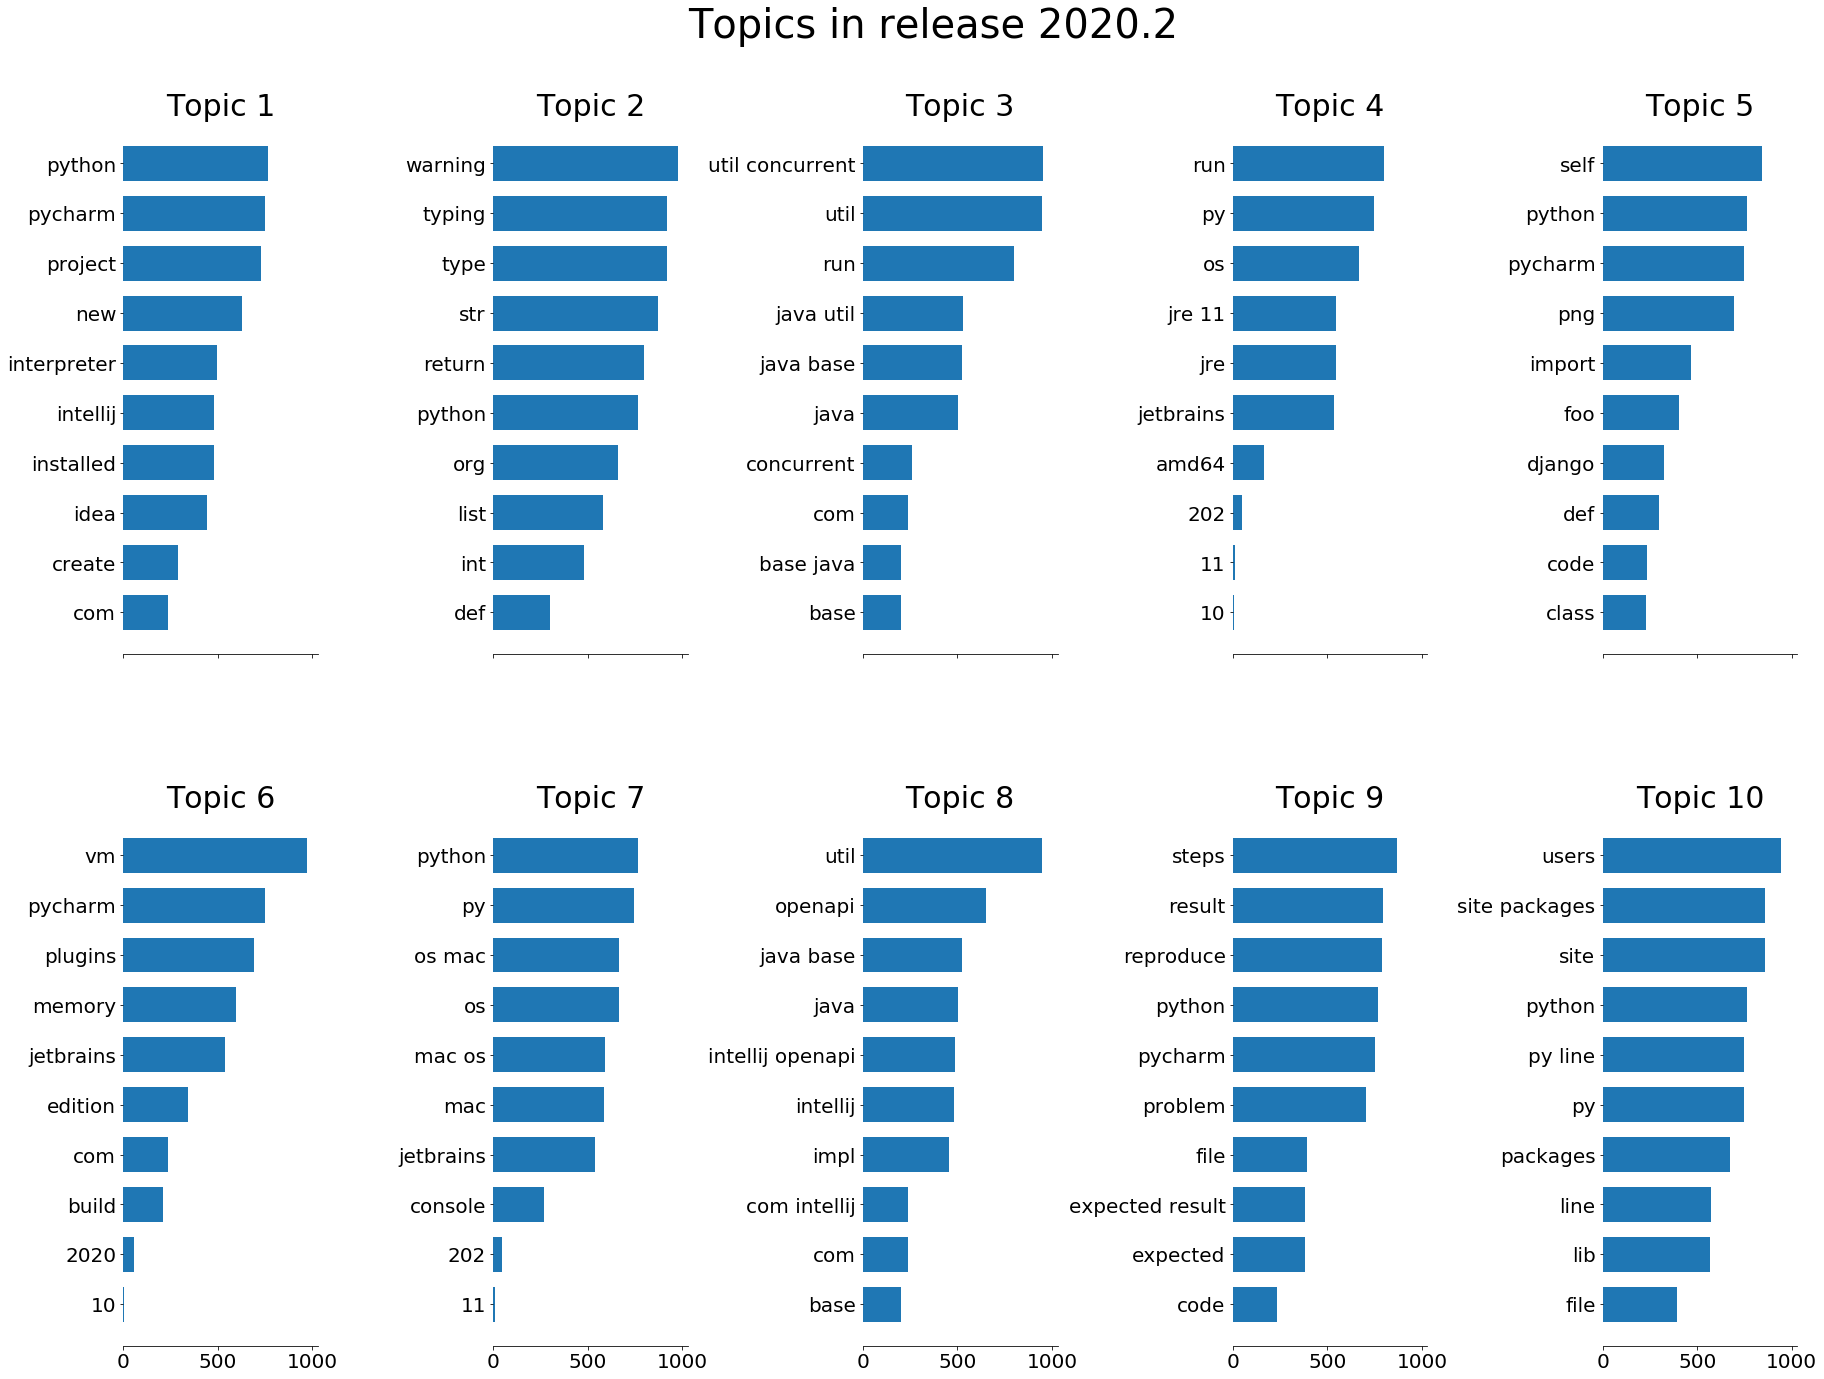

In [202]:
generate_top_words_barplot(top_words[10]['2020.2'], 'Topics in release 2020.2')

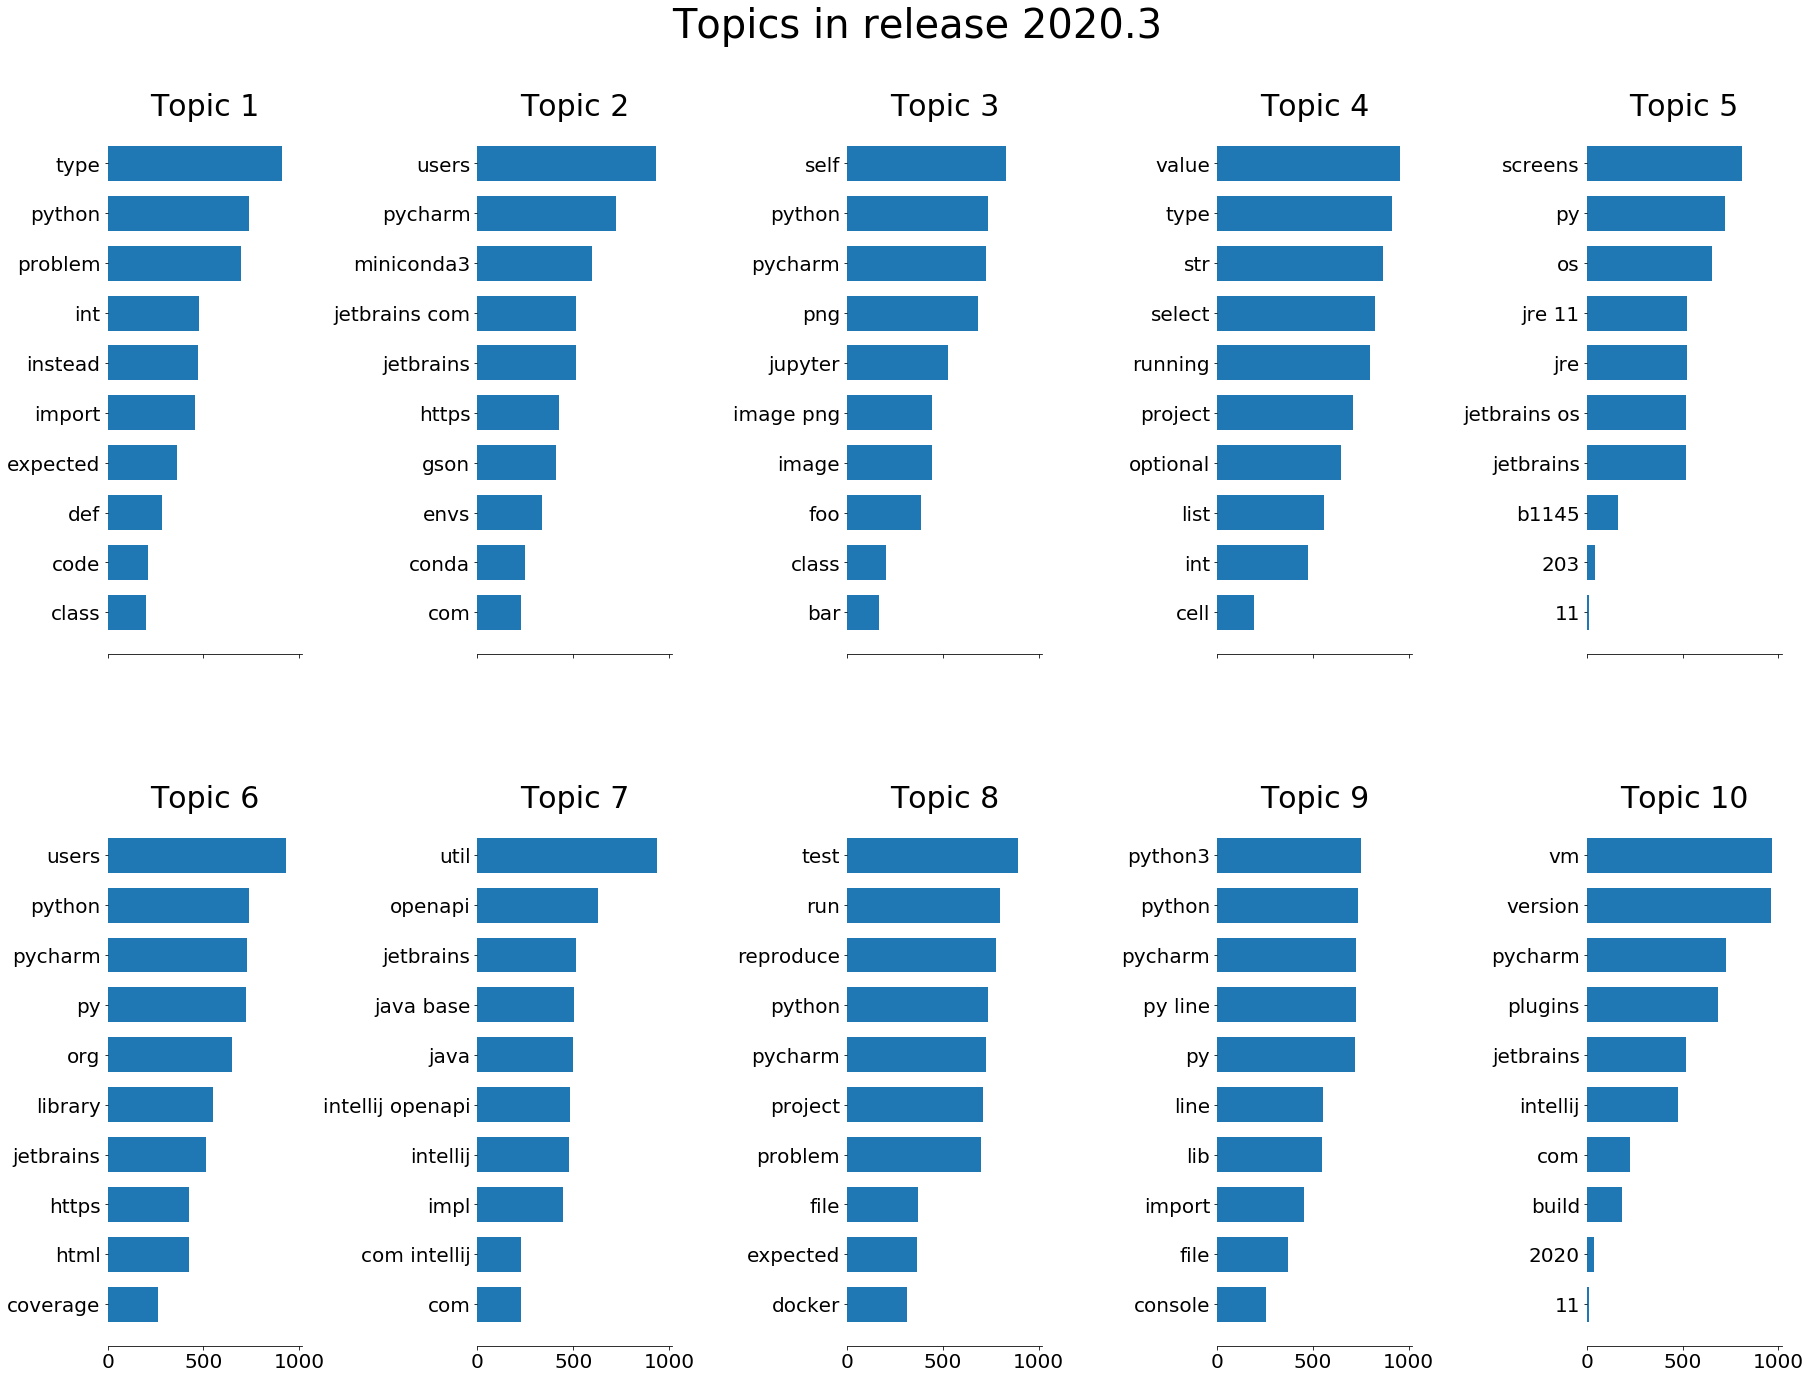

In [203]:
generate_top_words_barplot(top_words[10]['2020.3'], 'Topics in release 2020.3')

Thus, we can identify some issues relevant to each release. The problem with this approach is that it is pretty sophisticated to match the topics between the different release versions. Therefore, let's train an LDA model on all the releases **simultaneously**.

In [185]:
all_issues = pd.concat([issues_by_version[version] for version in versions], ignore_index=True)

In [204]:
top_words = {}
for n_components in [4, 10]:
    tf_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    tfs = tf_vectorizer.fit_transform(all_issues['full_text'].values.astype('U'))
    lda = LatentDirichletAllocation(n_components=n_components, random_state=RANDOM_STATE)
    lda.fit(tfs)
    top_words[n_components] = find_top_words_sklearn(lda, tf_vectorizer.get_feature_names())

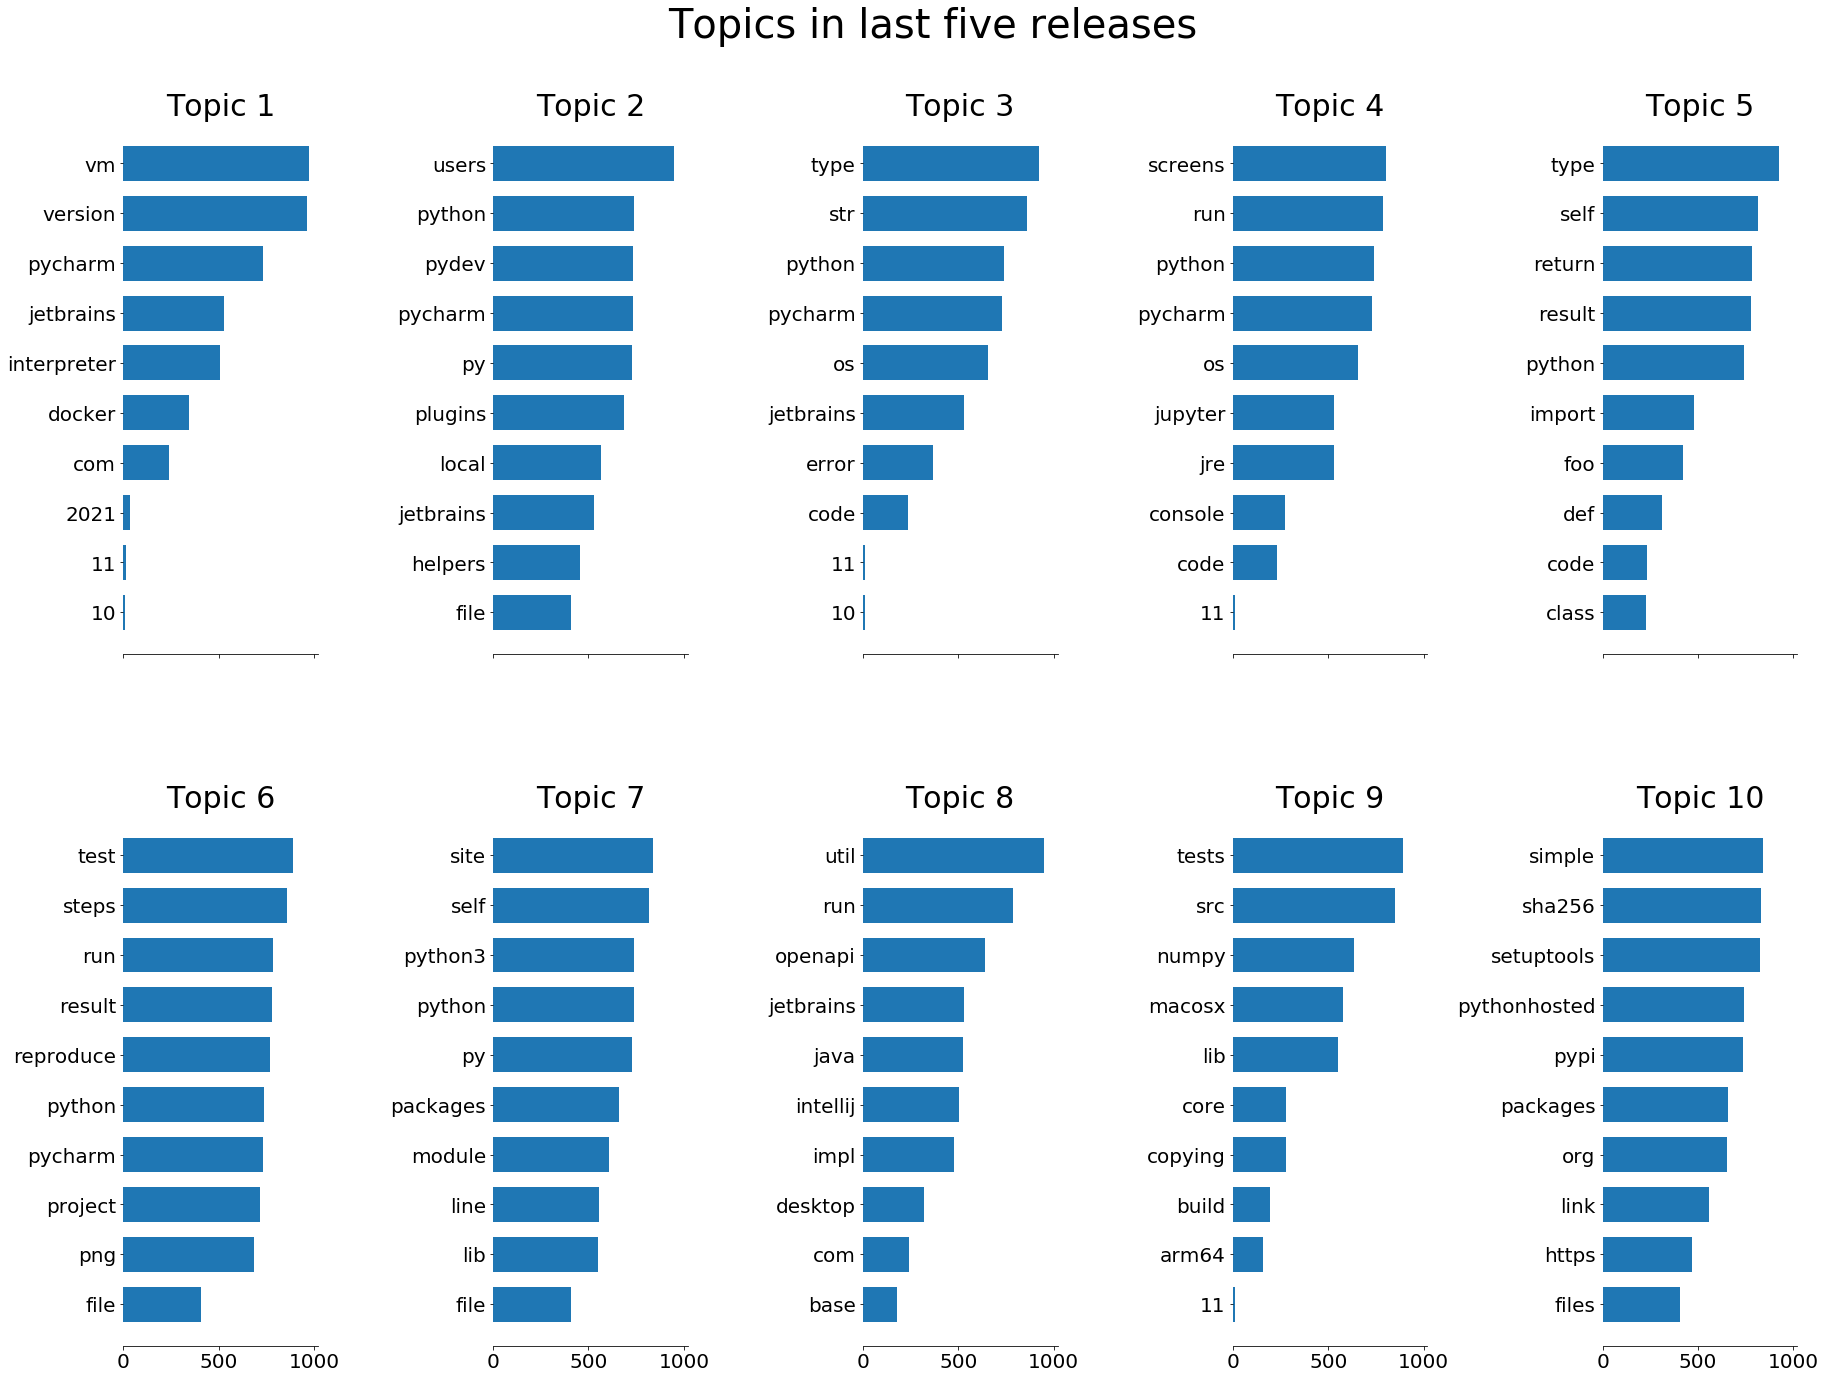

In [205]:
generate_top_words_barplot(top_words[10], 'Topics in last five releases')

In [190]:
def build_topics_chart(title, topics_distribution):
    plt.pie(topics_distribution, labels=[f'Topic {i}' for i in range(1, 11)])
    plt.title(title)
    plt.show()

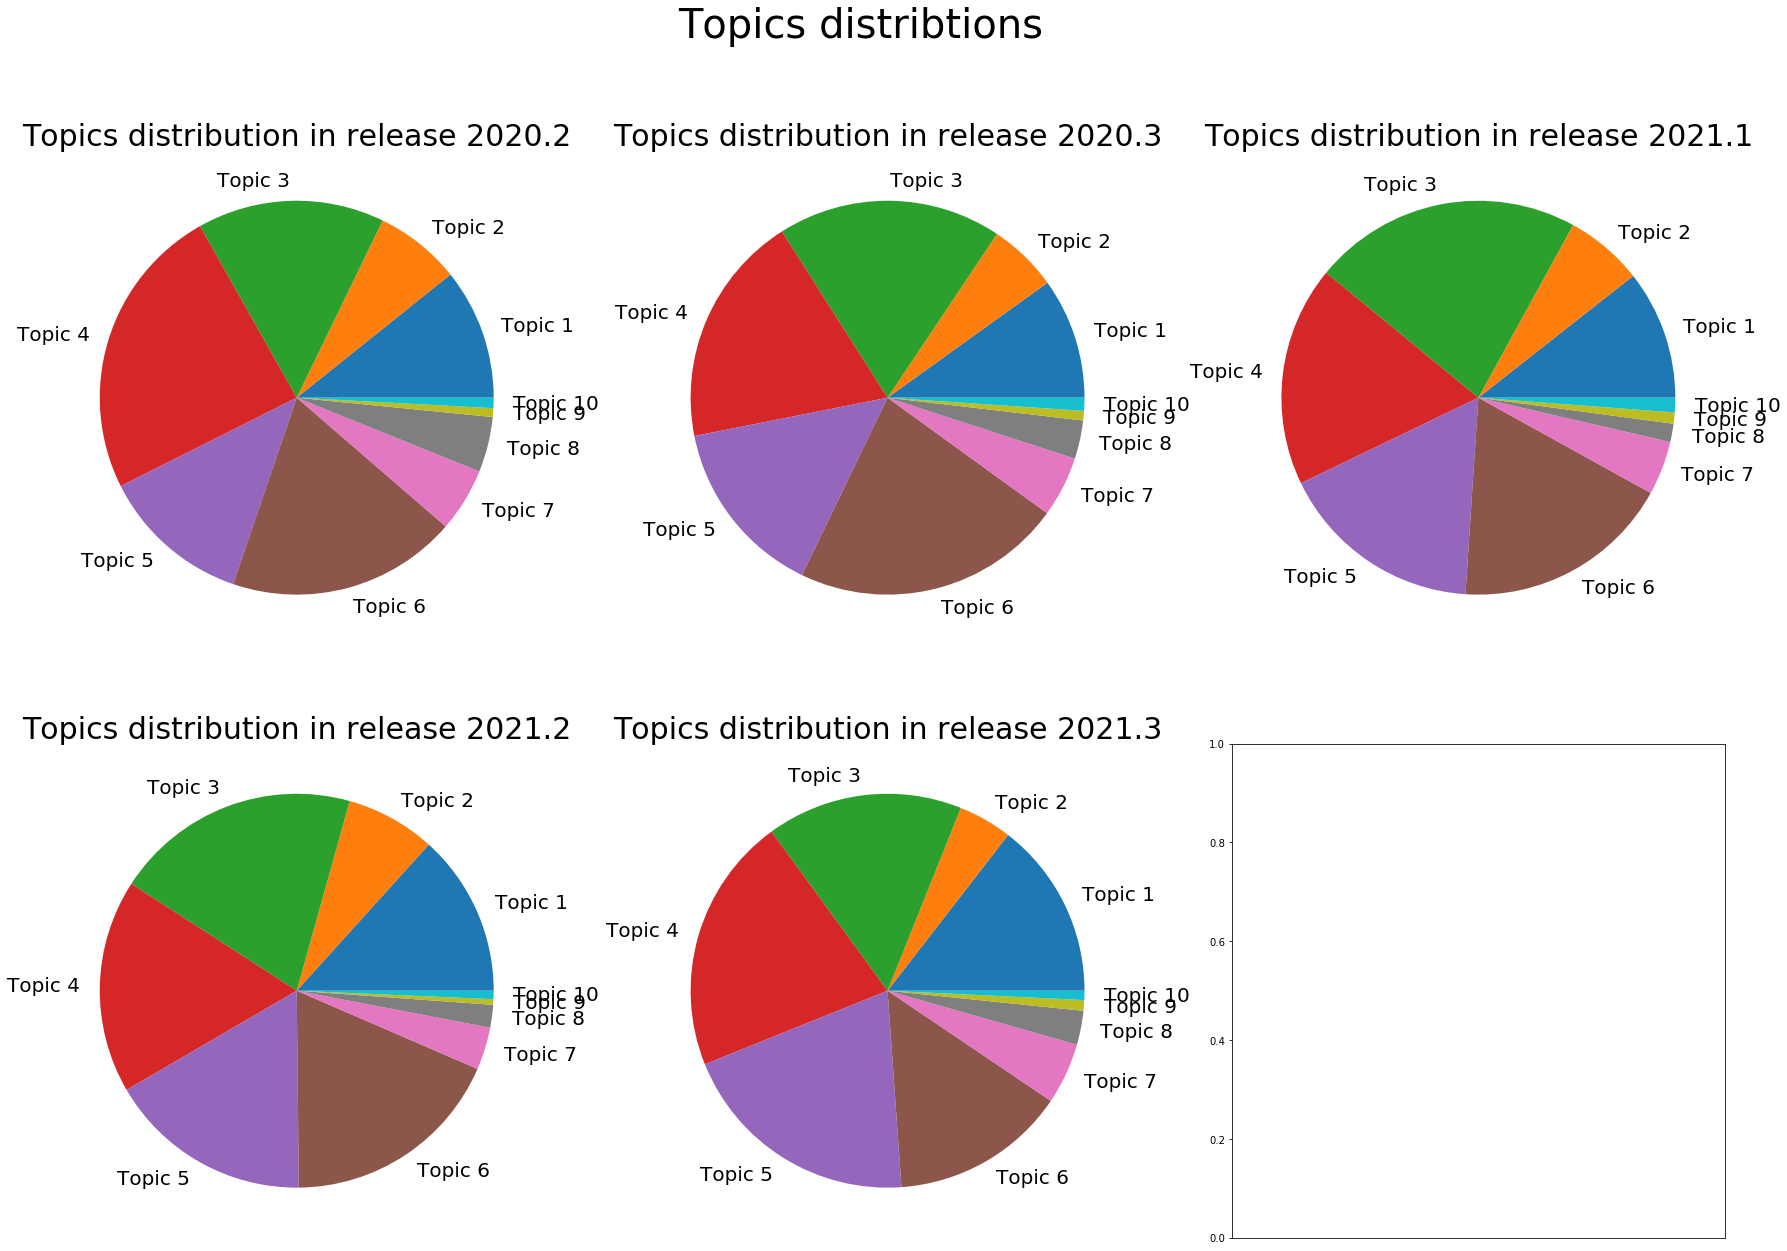

In [214]:
fig, axes = plt.subplots(2, 3, figsize=(30, 20), sharex=True)
axes = axes.flatten()
for i, version in enumerate(versions):
    ax = axes[i]
    tfs = tf_vectorizer.transform(issues_by_version[version]['full_text'].values.astype('U'))
    distribution = lda.transform(tfs).mean(axis=0)
    ax.pie(distribution, labels=[f'Topic {i}' for i in range(1, 11)], textprops={'fontsize': 20})
    ax.set_title(f'Topics distribution in release {version}', fontdict={'fontsize': 30})
plt.suptitle(f'Topics distribtions', fontsize=40)
plt.show()

The problem with this plot is the same as we discussed during the lecture: the distributions are very static! It is impossible to say if some new issues appeared or disappeared between the releases 2020.2 and 2020.3.

## Conclusion

There are two different approaches:
* Build topics for all the releases independently. Then, it is hard to match them between releases (and we can only rely on the issues identified by the top words; it is not are not reliable without experts).
* Build topics for all the releases simultaneously. Then they are similar as well as topics distributions. More specifically, in this approach, it is impossible to include all the existing issues which do not appear in all the releases without increasing the n_components arguments (which affect our performance).

Thus, the task is _actually_ sophisticated.